In [1]:
import urllib, pandas, numpy, igraph

In [2]:
# pip install git+https://github.com/Maayanlab/maayanlab-bioinformatics.git
import maayanlab_bioinformatics, maayanlab_bioinformatics.enrichment

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

In [4]:
enrichr_library = 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X'

In [5]:
inputfile = '/Users/adrian/hub/vigur/003.proteomics/colored_proteins_24.tsv'
df = pandas.read_csv(inputfile, sep='\t')
df.head()

,Uniprot_ID,Uniprot_gene_ID,Gene_name,ENSEMBL,Description,Color_in_plot,log2FC,Adjusted_P_value
0,P30520,PURA2_HUMAN,ADSS2,ENSG00000035687,Adenylosuccinate synthetase isozyme 2,blue,-0.362995,0.022183
1,B7ZBQ3,B7ZBQ3_HUMAN,MED20,ENSG00000124641,Mediator of RNA polymerase II transcription su...,blue,-0.506240,0.045739
2,Q9BYC9,RM20_HUMAN,MRPL20,ENSG00000242485,"39S ribosomal protein L20, mitochondrial",blue,-0.496515,0.003015
3,Q9Y6D5,BIG2_HUMAN,ARFGEF2,ENSG00000124198,Brefeldin A-inhibited guanine nucleotide-excha...,orange,0.183811,0.046504
4,O95218,ZRAB2_HUMAN,ZRANB2,ENSG00000132485,Zinc finger Ran-binding domain-containing prot...,blue,-0.554378,0.043149


In [6]:
sub = df[(df['Color_in_plot'] == 'blue') | (df['Color_in_plot'] == 'red')] # get blue or red. Another notebook for 4 hours.
v = list(sub['Gene_name'].dropna())
genes = list(set(v))
gene_list = [x.strip() for x in genes]
print(len(gene_list))

1644


In [7]:
def get_library(lib_name):
    '''
    Returns a dictionary mapping each term from the input library to 
    its associated geneset. 
    '''
    raw_lib_data = []

    with urllib.request.urlopen('https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName=' + lib_name) as f:
        for line in f.readlines():
            raw_lib_data.append(line.decode("utf-8").split("\t\t"))

    #print('raw', raw_lib_data[:10], len(raw_lib_data))

    name = []
    gene_list = []
    lib_data = {}

    for i in range(len(raw_lib_data)):
        name += [raw_lib_data[i][0]]
        raw_genes = raw_lib_data[i][1].replace('\t', ' ')
        gene_list += [raw_genes[:-1]]
    
    lib_data = {a[0]:a[1].split(' ') for a in zip(name, gene_list)}
    return lib_data

lib_data = get_library(enrichr_library) # lib_data contains the background
enrich_results = maayanlab_bioinformatics.enrichment.enrich_crisp(genes, lib_data, 21000, True)

res_df = pandas.DataFrame(
    [ [
        term, 
        res.pvalue, 
        res.odds_ratio,
        res.n_overlap,

    ] for (term, res) in enrich_results ], 
    columns=['term', 'pvalue', 'odds_ratio', 'n_overlap']
)
res_df

,term,pvalue,odds_ratio,n_overlap
0,NANOG CHEA,6.840861e-04,1.565255,69
1,AR CHEA,9.007088e-02,1.166035,98
2,ETS1 ENCODE,8.490518e-05,2.469445,27
3,ZC3H11A ENCODE,4.400033e-01,1.088922,11
4,E2F6 ENCODE,6.816054e-21,1.817173,393
...,...,...,...,...
99,BHLHE40 ENCODE,1.094471e-06,2.194423,54
100,EZH2 CHEA,9.999999e-01,0.098681,2
101,KAT2A ENCODE,3.578471e-07,4.024604,23
102,UBTF ENCODE,5.989707e-15,1.904735,215


(71, 4)
(33, 4)
1	80.04840199843422	TAF1 ENCODE
2	57.374584057354056	MAX ENCODE
3	51.60038992918191	MYC ENCODE
4	47.23273134112063	YY1 ENCODE
5	40.80163385537369	BRCA1 ENCODE
6	38.971240846241066	ATF2 ENCODE
7	31.262152492634087	NFYB ENCODE
8	31.041851100629003	MYC CHEA
9	28.375953871102414	PML ENCODE
10	26.943566985458805	USF2 ENCODE
11	25.70732107395978	USF1 ENCODE
12	23.904635578055167	GABPA ENCODE
13	21.07748667117422	E2F1 CHEA
14	20.102163182151642	CREB1 CHEA
15	19.57487376264274	NRF1 ENCODE
16	18.670466218146164	SIN3A ENCODE
17	17.276500119919728	ZMIZ1 ENCODE
18	16.54244129174399	CHD1 ENCODE
19	13.5373873709087	SPI1 CHEA
20	12.645313732119362	TCF3 ENCODE
21	11.648398349264808	ZNF384 ENCODE
22	10.911982005174941	FLI1 ENCODE
23	10.310481777425036	RCOR1 ENCODE
24	9.853022372023686	YY1 CHEA
25	7.599490045922515	KAT2A ENCODE
26	6.704287535669401	IRF1 ENCODE
27	6.519784989561533	NELFE ENCODE
28	6.351895381940682	BHLHE40 ENCODE
29	5.723695511233273	PPARD CHEA
30	4.928539379155832	NFIC E

/var/folders/j2/645ctp717nv8rwbn2dsccyxh0000gn/T/ipykernel_9171/2438057308.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.loc[:, 'importance'] = importance


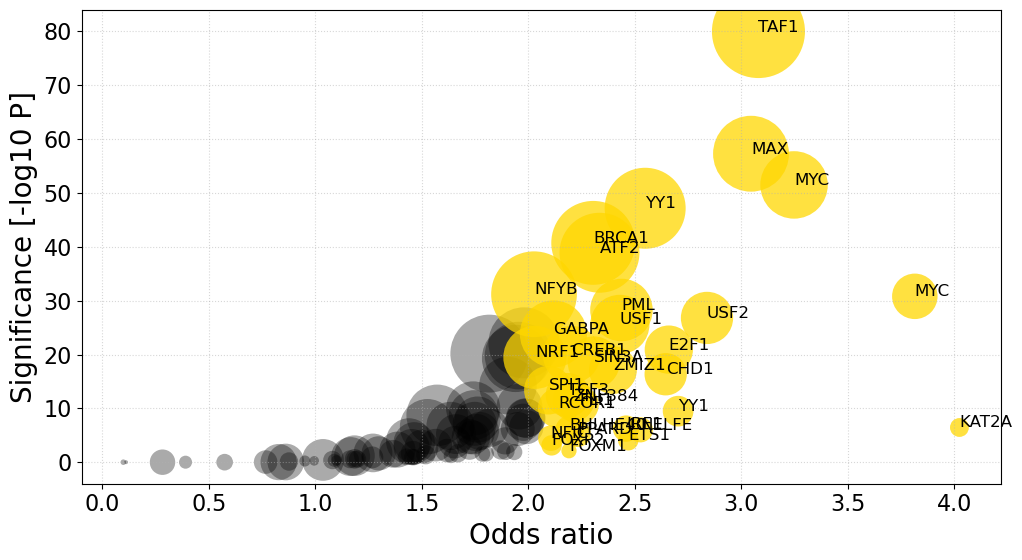

In [8]:
a = res_df[(res_df['pvalue'] > 0.05) | (res_df['odds_ratio'] < 2)]
print(a.shape)
x = a['odds_ratio']
y = -numpy.log10(a['pvalue'])
s = a['n_overlap']
matplotlib.pyplot.scatter(x, y, s*8, alpha=1/3, edgecolors='none', color='black')

b = res_df[(res_df['pvalue'] < 0.05) & (res_df['odds_ratio'] > 2)]
print(b.shape)
x = b['odds_ratio']
y = -numpy.log10(b['pvalue'])
s = b['n_overlap']
sc = matplotlib.pyplot.scatter(x, y, s*8, alpha=3/4, edgecolors='none', color='gold')

x = list(b['odds_ratio'])
y = list(-numpy.log10(b['pvalue']))
importance = [numpy.sqrt(x[i]**2 + y[i]**2) for i in range(len(x))]
b.loc[:, 'importance'] = importance
c = b.sort_values('importance', ascending=False)

threshold = 0 # seven
com = c[c['importance'] > threshold]
count = 0
for index, row in com.iterrows():
    x = row['odds_ratio']
    y = -numpy.log10(row['pvalue'])
    label = row['term'].split()[0]
    matplotlib.pyplot.text(x, y, label, fontsize=12)
    count = count + 1
    print('{}\t{}\t{}'.format(count, row['importance'], row['term']))

#matplotlib.pyplot.legend(*sc.legend_elements("sizes", num=4))
#matplotlib.pyplot.xlim(0, 17)
matplotlib.pyplot.xlabel('Odds ratio')
matplotlib.pyplot.ylabel('Significance [-log10 P]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()

matplotlib.pyplot.show()

In [9]:
print(c.shape)
c

(33, 5)


,term,pvalue,odds_ratio,n_overlap,importance
79,TAF1 ENCODE,1.025435e-80,3.080887,561,80.048402
18,MAX ENCODE,5.085427e-58,3.045977,373,57.374584
43,MYC ENCODE,3.176382e-52,3.247970,295,51.600390
6,YY1 ENCODE,6.856373e-48,2.548906,425,47.232731
67,BRCA1 ENCODE,1.834563e-41,2.305114,456,40.801634
75,ATF2 ENCODE,1.255302e-39,2.334569,414,38.971241
31,NFYB ENCODE,6.362645e-32,2.027106,476,31.262152
82,MYC CHEA,1.561280e-31,3.815087,134,31.041851
22,PML ENCODE,5.357182e-29,2.437564,253,28.375954
93,USF2 ENCODE,1.608608e-27,2.839278,177,26.943567


In [10]:
ourtfs = c['term'].values
for tf in ourtfs:
    print(tf)
    for target in lib_data[tf]:
        if target in ourtfs:
            print('\t', tf, target)
    
        

TAF1 ENCODE
MAX ENCODE
MYC ENCODE
YY1 ENCODE
BRCA1 ENCODE
ATF2 ENCODE
NFYB ENCODE
MYC CHEA
PML ENCODE
USF2 ENCODE
USF1 ENCODE
GABPA ENCODE
E2F1 CHEA
CREB1 CHEA
NRF1 ENCODE
SIN3A ENCODE
ZMIZ1 ENCODE
CHD1 ENCODE
SPI1 CHEA
TCF3 ENCODE
ZNF384 ENCODE
FLI1 ENCODE
RCOR1 ENCODE
YY1 CHEA
KAT2A ENCODE
IRF1 ENCODE
NELFE ENCODE
BHLHE40 ENCODE
PPARD CHEA
NFIC ENCODE
ETS1 ENCODE
FOXP2 ENCODE
FOXM1 ENCODE


In [11]:
%%time
tflink = pandas.read_csv('/Users/adrian/scratch/TFLink_Homo_sapiens_interactions_All_simpleFormat_v1.0.tsv', sep='\t')

CPU times: user 8.13 s, sys: 1.1 s, total: 9.22 s
Wall time: 9.49 s


In [12]:
tflink

,UniprotID.TF,UniprotID.Target,NCBI.GeneID.TF,NCBI.GeneID.Target,Name.TF,Name.Target,Detection.method,PubmedID,Organism,Source.database,Small-scale.evidence,TF.TFLink.ortho,TF.nonTFLink.ortho,Target.TFLink.ortho,Target.nonTFLink.ortho
0,Q9H9S0,O94907,79923,22943,NANOG,DKK1,chromatin immunoprecipitation assay;inferred b...,19148141;29087512;29126285;27924024,Homo sapiens,GTRD;ReMap;TRRUST,Yes,-,-,Dr:Q9PWH3;Dr:F1RBK0;Mm:O54908,Rn:D3Z9J1
1,P37231,P10826,5468,5915,PPARG,RARB,chromatin immunoprecipitation assay;inferred b...,17202159;12839938;29087512;27924024,Homo sapiens,GTRD;TRED;TRRUST,Yes,-,-,Mm:P22605;Rn:D3ZFD9,-
2,P10242,P08047,4602,6667,MYB,SP1,chromatin immunoprecipitation assay;inferred b...,29126285;27924024;17202159,Homo sapiens,GTRD;ReMap;TRED,Yes,Dr:F1QP24;Rn:A0A0G2K2A4,Mm:A0A087WPA7,Dr:F1QW97;Rn:Q01714,Mm:G3X8Q0
3,P31269,Q02363,3205,3398,HOXA9,ID2,inferred by curator,29087512;20565746,Homo sapiens,TRRUST,Yes,Mm:P09631,Rn:D3ZSU5,Dr:Q7SZQ2;Mm:P41136;Rn:P41137,-
4,P03372,P17275,2099,3726,ESR1,JUNB,chromatin immunoprecipitation assay;inferred b...,29126285;18971253;27924024;11477071;17202159;2...,Homo sapiens,GTRD;PAZAR;ReMap;TRED;TRRUST,Yes,Mm:P19785,Rn:A0A0G2K0D4,Dr:A8E7N0;Mm:P09450;Rn:A0A0G2JSY8,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6739352,Q8TF68,Q9HBW0,171017,9170,ZNF384,LPAR2,chromatin immunoprecipitation assay,27924024,Homo sapiens,GTRD,No,Rn:G3V9M5,Dr:I3ITQ6;Mm:E9Q1A5,Dr:F1Q734;Mm:Q6P290;Rn:A0A0G2K505,-
6739353,O96006,P08670,9189,7431,ZBED1,VIM,chromatin immunoprecipitation assay,27924024,Homo sapiens,GTRD,No,-,-,Mm:P20152;Rn:G3V8C3,Dr:F1QAM8;Dr:F1QT60
6739354,Q8IYM9,Q13286,10346,1201,TRIM22,CLN3,chromatin immunoprecipitation assay,29126285;27924024,Homo sapiens,GTRD;ReMap,No,-,-,-,-
6739355,Q9NZC4,Q8N883,26298,80110,EHF,ZNF614,chromatin immunoprecipitation assay,27924024,Homo sapiens,GTRD,No,-,-,-,-


In [13]:
small = tflink[tflink['Small-scale.evidence'] == 'Yes']
print(small.shape)

(16634, 15)


In [14]:
targets = tflink[tflink['Name.TF'] == 'MYC']['Name.Target'].to_list()
print(len(targets))

18182


In [15]:
print(tflink.shape)
df = tflink[tflink['Name.TF'] == 'IRF8']
#print(df.shape)
#df = df[df['Name.Target'].isin(ourtfs)]
#print(df.shape)
df

(6739357, 15)


,UniprotID.TF,UniprotID.Target,NCBI.GeneID.TF,NCBI.GeneID.Target,Name.TF,Name.Target,Detection.method,PubmedID,Organism,Source.database,Small-scale.evidence,TF.TFLink.ortho,TF.nonTFLink.ortho,Target.TFLink.ortho,Target.nonTFLink.ortho
297,Q02556,O00206,3394,7099,IRF8,TLR4,inferred by curator,29087512;10734131,Homo sapiens,TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Mm:Q9QUK6,Dr:F6NLN8;Dr:B8A691;Rn:G3V7D8
381,Q02556,P22301,3394,3586,IRF8,IL10,inferred by curator,20709027;29087512,Homo sapiens,TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Dr:Q5EFQ8;Mm:P18893,Rn:P29456
581,Q02556,P21359,3394,4763,IRF8,NF1,inferred by curator,15371411;29087512,Homo sapiens,TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Dr:E7FFY1;Mm:Q04690,Dm:Q8IMS2;Rn:F1LM28
1078,Q02556,P33076,3394,4261,IRF8,CIITA,inferred by curator,11777970;20211142,Homo sapiens,FANTOM4_via_DoRothEA,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,-,-
1520,Q02556,O15519,3394,8837,IRF8,CFLAR,inferred by curator,29087512;19155307,Homo sapiens,TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Dr:F1R706;Mm:O35732;Rn:C0H5Y5,-
6348,Q02556,P04839,3394,1536,IRF8,CYBB,electrophoretic mobility shift assay;inferred ...,9593745;29087512;22900683,Homo sapiens,HTRI;TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Mm:Q61093,Dr:F1QV52;Rn:Q9ERL1
8751,Q02556,P29459,3394,3592,IRF8,IL12A,inferred by curator,16622221;29087512;27899662,Homo sapiens,KEGG_via_DoRothEA;TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,-,-
9680,Q02556,P01584,3394,3553,IRF8,IL1B,inferred by curator,17386941;29087512,Homo sapiens,TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Dr:A0A0R4IYF1;Mm:P10749,Rn:Q5BKB0
11635,Q02556,P19878,3394,4688,IRF8,NCF2,inferred by curator,29087512;10570299,Homo sapiens,TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Mm:O70145,Dr:A2VCY2
12203,Q02556,O15455,3394,7098,IRF8,TLR3,inferred by curator,21220691;29087512,Homo sapiens,TRRUST,Yes,Mm:P23611;Rn:Q5NUI4,Dr:Q6DHK7,Mm:Q99MB1;Rn:F1LN63,Dr:B8JIL3


In [16]:
a = ['sd', 'sdd']
a.index('sdd')

1

In [17]:
ourtfs = list(set([element.split(' ')[0] for element in c['term'].values]))
ourtfs.sort()

interactions = []

for tf in ourtfs:
    print(tf)
    df = small[small['Name.TF'] == tf]
    print(df.shape)
    df = df[df['Name.Target'].isin(ourtfs)]

    print(df.shape)
    print(df[['Name.TF', 'Name.Target']])

    for tmp, row in df.iterrows():
        print(ourtfs.index(row['Name.TF']), ourtfs.index(row['Name.Target'])) 

        a = ourtfs.index(row['Name.TF'])
        b = ourtfs.index(row['Name.Target'])
        interactions.append([a, b])
    
    print()

ATF2
(56, 15)
(1, 15)
      Name.TF Name.Target
12242    ATF2        ATF2
0 0

BHLHE40
(0, 15)
(0, 15)
Empty DataFrame
Columns: [Name.TF, Name.Target]
Index: []

BRCA1
(71, 15)
(2, 15)
      Name.TF Name.Target
15315   BRCA1         MYC
16111   BRCA1        ETS1
2 14
2 6

CHD1
(0, 15)
(0, 15)
Empty DataFrame
Columns: [Name.TF, Name.Target]
Index: []

CREB1
(245, 15)
(4, 15)
     Name.TF Name.Target
391    CREB1       BRCA1
3841   CREB1        FLI1
8027   CREB1       GABPA
8602   CREB1        NRF1
4 2
4 7
4 10
4 18

E2F1
(772, 15)
(5, 15)
      Name.TF Name.Target
213      E2F1         MYC
1136     E2F1       FOXM1
11473    E2F1         YY1
12140    E2F1        E2F1
13616    E2F1       BRCA1
5 14
5 8
5 28
5 5
5 2

ETS1
(214, 15)
(4, 15)
     Name.TF Name.Target
5406    ETS1         MYC
5671    ETS1        FLI1
6165    ETS1        ETS1
9886    ETS1       GABPA
6 14
6 7
6 6
6 10

FLI1
(51, 15)
(2, 15)
      Name.TF Name.Target
653      FLI1       FOXM1
16631    FLI1        FLI1
7 8
7 7

F

In [18]:
interactions

[[0, 0],
 [2, 14],
 [2, 6],
 [4, 2],
 [4, 7],
 [4, 10],
 [4, 18],
 [5, 14],
 [5, 8],
 [5, 28],
 [5, 5],
 [5, 2],
 [6, 14],
 [6, 7],
 [6, 6],
 [6, 10],
 [7, 8],
 [7, 7],
 [8, 14],
 [10, 2],
 [11, 5],
 [11, 14],
 [13, 14],
 [14, 28],
 [14, 5],
 [14, 2],
 [14, 14],
 [14, 8],
 [14, 4],
 [16, 14],
 [19, 19],
 [20, 14],
 [22, 5],
 [23, 23],
 [23, 7],
 [25, 14],
 [26, 2],
 [26, 14],
 [27, 2],
 [28, 14],
 [28, 2]]

In [20]:
g = igraph.Graph(edges=interactions)
layout = g.layout("kk")


In [21]:
g.vs["label"] = ourtfs

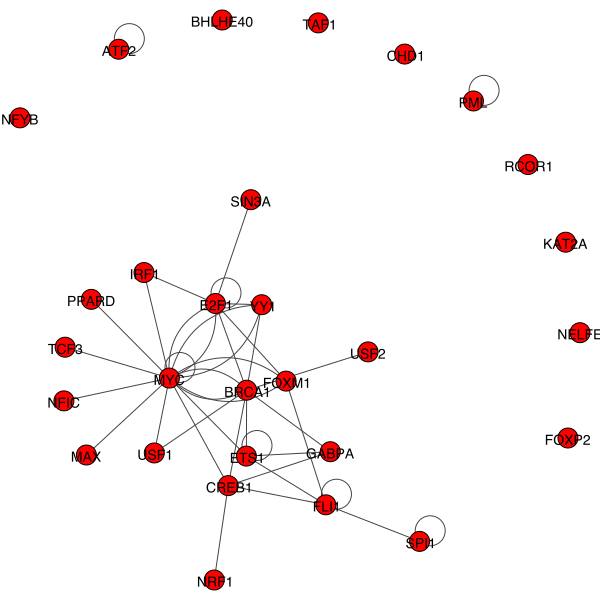

In [22]:
igraph.plot(g, layout=layout)